## Desafío - Mecanismos de Votación

<br>
<div class="alert alert-block alert-success">

<b>Nombre:</b> Alexandra Bobet

<b>Generación:</b> G12

<b>Profesor:</b> Gabriel Tamayo L.

</div>


* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

#### Descripción
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o
inpopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos
registrados son de la página web www.mashable.com. 

Más información sobre los atributos se puede encontrar en el archivo OnlineNewsPopularity.names.

### Ejercicio 1 - Preparación del Ambiente de Trabajo
* A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función grid_plot_batch que se encuentra en el archivo helpers.py.

```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

```

* Describa el comportamiento de las variables.
* Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función identify_high_correlations que se encuentra en el archivo helpers.py . Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
* Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    * Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    * Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    * Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.
    
<div class="alert alert-block alert-warning">
<b>Tips:</b> 
    
   - La función identify_high_correlations retorna un dataframe con las columnas con mayor correlación. Debe eliminar solo una de las variables correlacionadas, utilice para esto los nombres de variables del campo 'variable' del df retornado.

</div>

In [1]:
# Importación Básica
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


import re
import helpers as hlp
from helpers import grid_plot_batch
from helpers import identify_high_correlations
from helpers import plot_classification_report

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
print('El dataset tiene: {} filas y {} columnas '.format(df.shape[0], df.shape[1]))
df.sample()

El dataset tiene: 39644 filas y 61 columnas 


url   timedelta  \
35131  http://mashable.com/2014/10/20/the-good-wife-s...        79.0   

        n_tokens_title   n_tokens_content   n_unique_tokens  \
35131              9.0              146.0          0.678082   

        n_non_stop_words   n_non_stop_unique_tokens   num_hrefs  \
35131                1.0                   0.814815         1.0   

        num_self_hrefs   num_imgs  ...   min_positive_polarity  \
35131              1.0        1.0  ...                     0.1   

        max_positive_polarity   avg_negative_polarity   min_negative_polarity  \
35131                     0.7               -0.155556               -0.155556   

        max_negative_polarity   title_subjectivity   title_sentiment_polarity  \
35131               -0.155556                  0.0                        0.0   

        abs_title_subjectivity   abs_title_sentiment_polarity   shares  
35131                      0.5                            0.0      580  

[1 rows x 61 columns]

In [3]:
# Elimina espacios en nombre columna

df.columns = [i.replace(' ', '') for i in df.columns]

# Elimina columna de url

df.drop(axis="columns", columns=["url"], inplace=True)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null float64
data_channel_is_socmed           39644 non-null flo

None

In [4]:
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

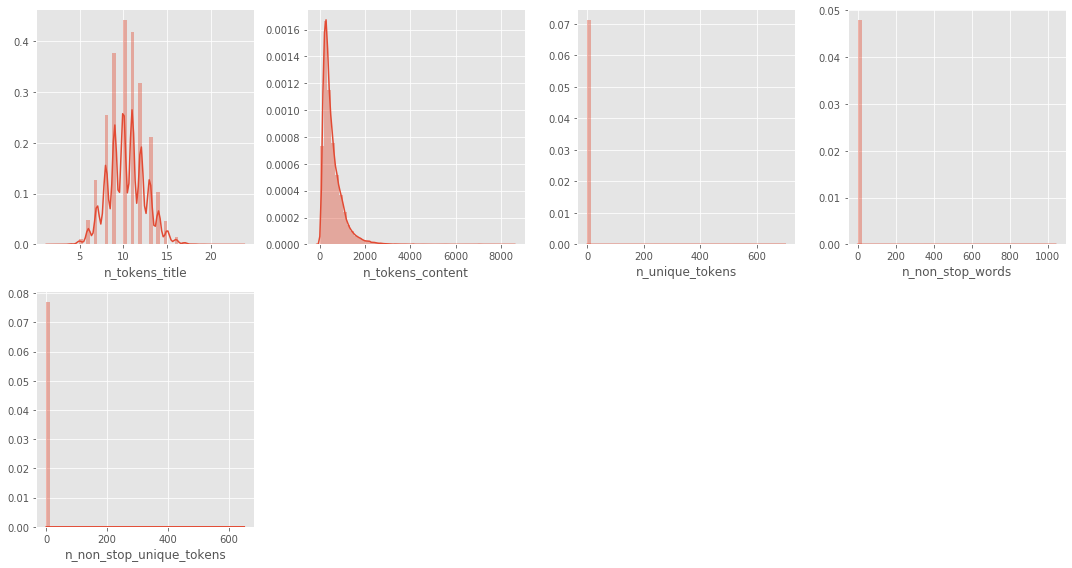

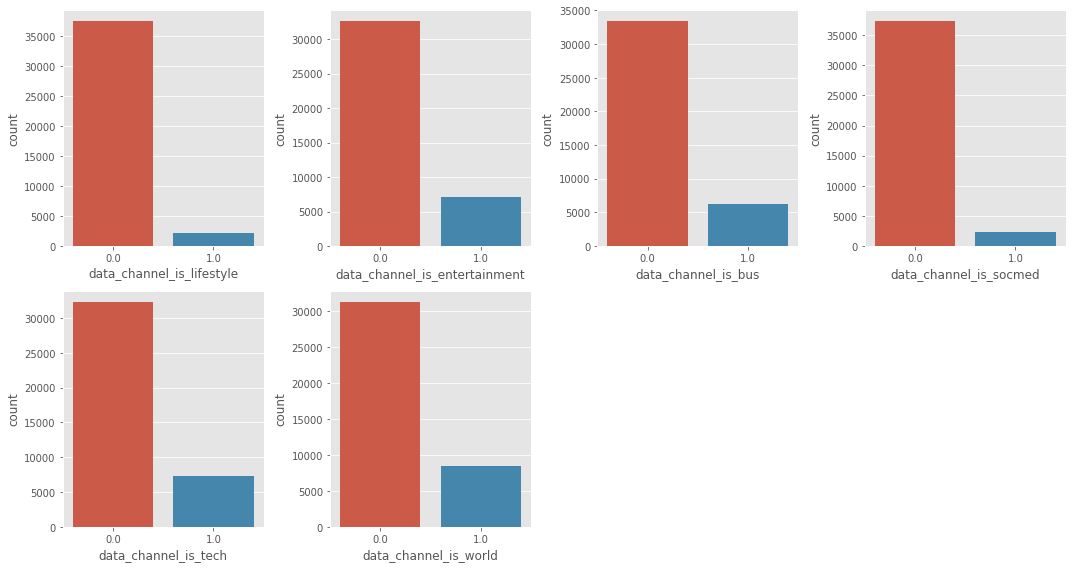

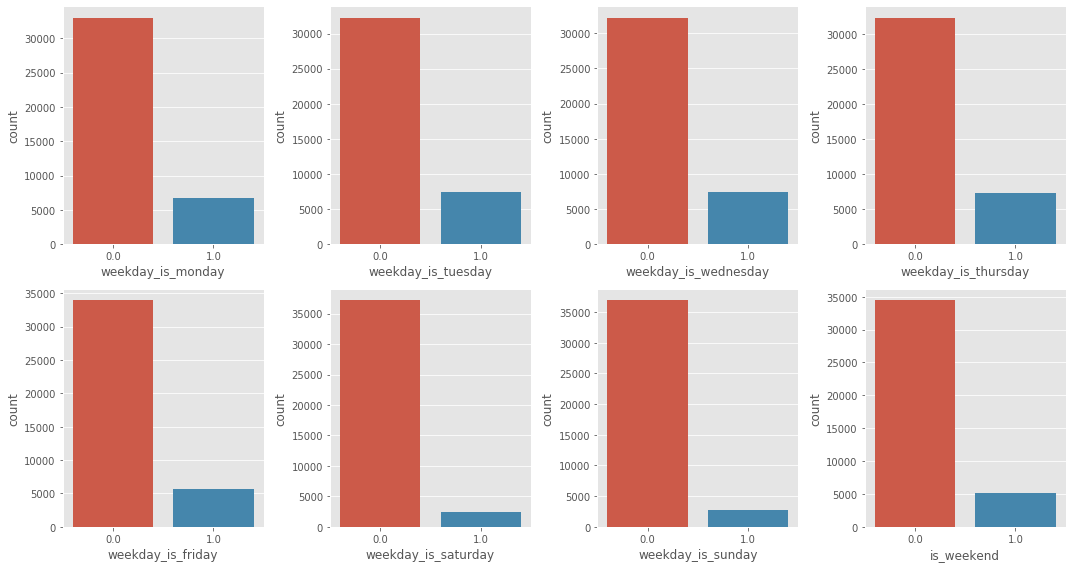

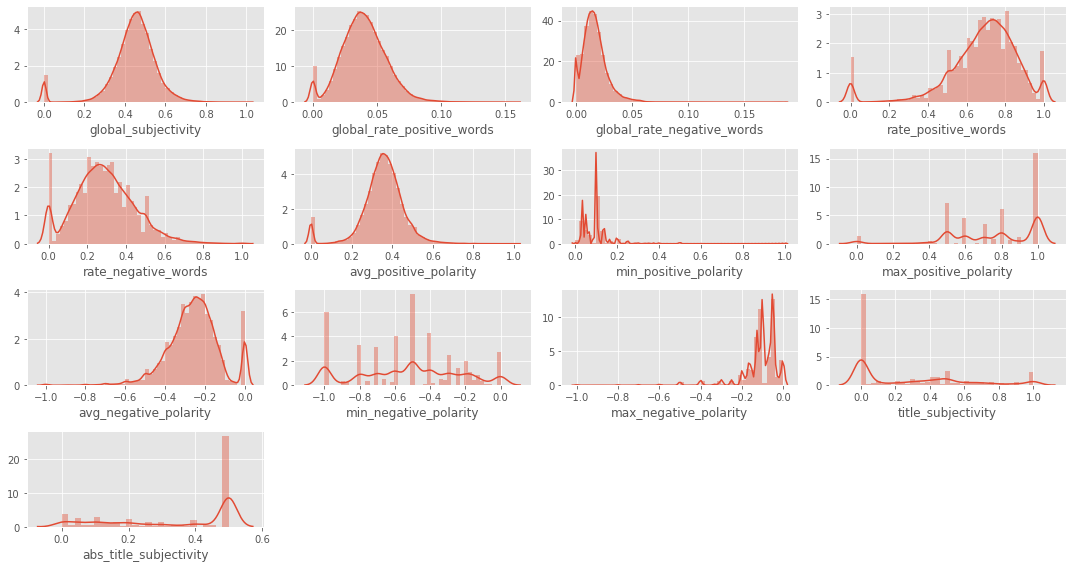

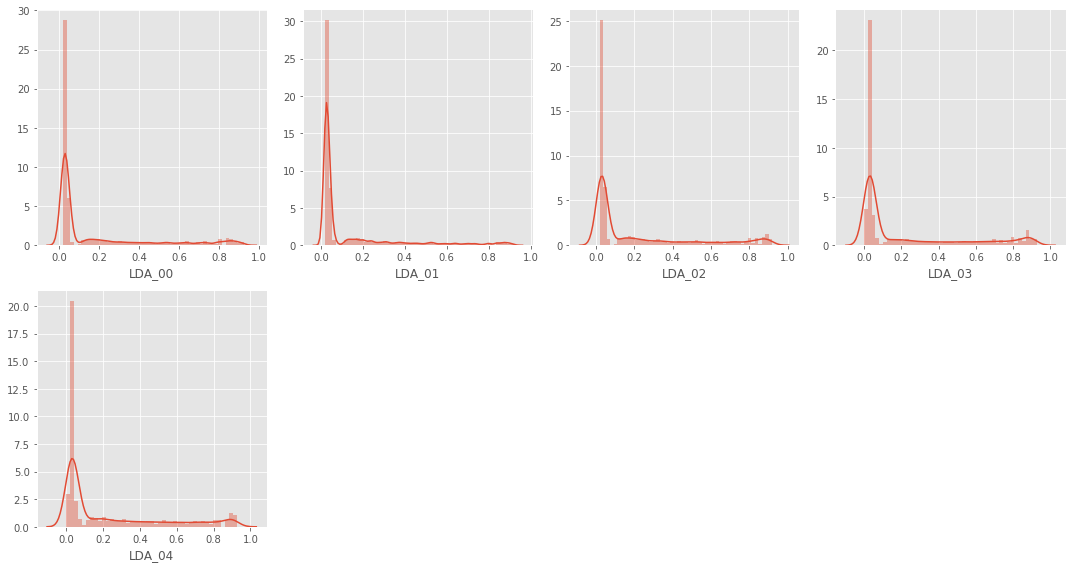

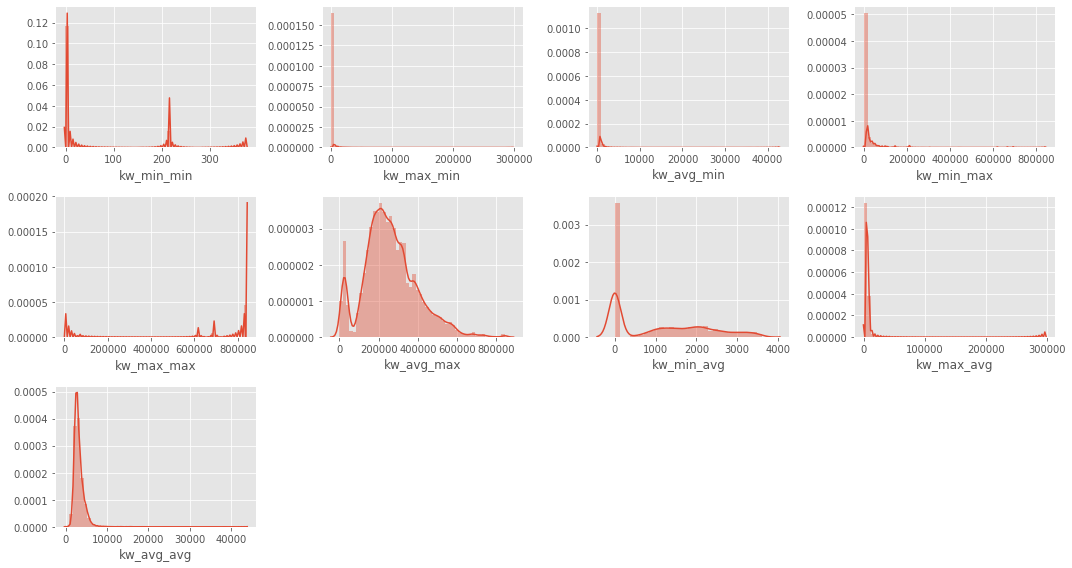

In [5]:
# Genera un lista de tuplas con variables y tipo de gráfico asociado(countplot para las preguntas si o no)

variables = [
    (qnty, sns.distplot),
    (channel, sns.countplot),
    (days, sns.countplot),
    (sentiments, sns.distplot),
    (lda, sns.distplot),
    (keywords, sns.distplot)
]

# Genera curvas de densidad y gráficos de barra
plt.rcParams['figure.figsize'] = (15, 8)
groups = 4
for var, plot_type in variables:
    grid_plot_batch(var, groups, plot_type)
    plt.tight_layout()
    plt.show()

### Diagnóstico previo de multicolinealidad

In [6]:
#Se identifican las siguientes correlaciones con valor mayor a 0,8.

corr = identify_high_correlations(df, threshold=0.8)
cols_to_drop = corr[corr["value"]>.8]["variable"].tolist()
cols_to_drop

['n_non_stop_words',
 'n_non_stop_unique_tokens',
 'n_non_stop_unique_tokens',
 'kw_avg_min',
 'kw_avg_avg',
 'self_reference_avg_sharess',
 'self_reference_avg_sharess',
 'LDA_02']

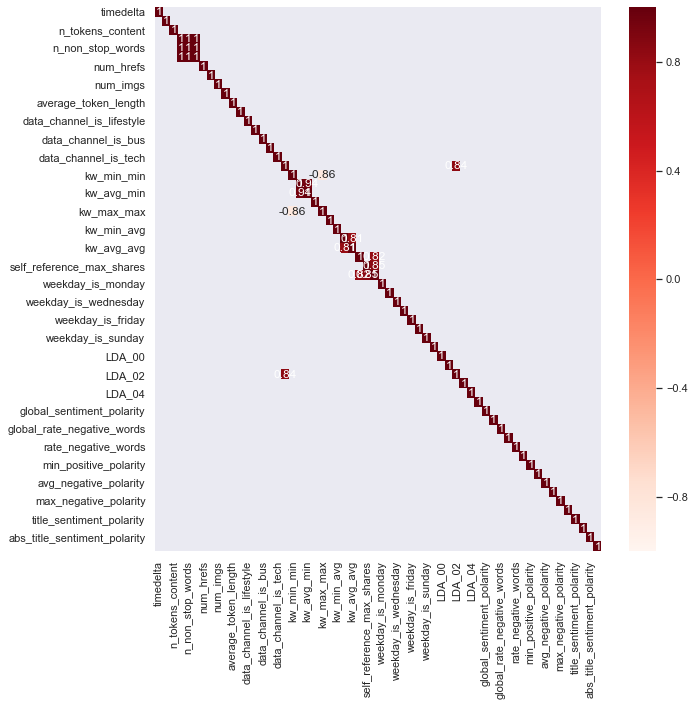

In [7]:
# Graficando la matriz de correlación entre los atributos
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.heatmap(df.corr()[abs(df.corr())>0.8], cmap='Reds',vmin=-1,vmax=1, annot=True, annot_kws={"fontsize":12});

In [8]:
# Recodifica variables shares

df["shares"] = np.where(df["shares"] > 1400, 1, 0)

# Del par de variables con alta correlación se elimina una

df.drop(axis="columns", columns=corr["var2"], inplace=True)

### Aplicar PCA

In [9]:
# Aplica PCA para obtener los principales 30 componentes 

var_objective = df["shares"]
var_attributes = df.drop(columns=["shares"])

X_mat_scale = StandardScaler().fit_transform(var_attributes)


In [10]:
# Define nombres de las columnas para los principales componentes

col_names = list(range(30))
col_names = ["comp_" + str(item).zfill(2) for item in col_names]

# Aplica PCA para obtener los principales 30 componentes y almacena datos en nuevo dataframe

pca = PCA(n_components=30)
principal_components = pca.fit_transform(X_mat_scale)

df_pca = pd.DataFrame(
    data=principal_components,
    columns=col_names
)

df_pca = pd.concat([df_pca, var_objective], axis = "columns")

df_pca

comp_00   comp_01   comp_02   comp_03   comp_04   comp_05   comp_06  \
0     -1.772400 -2.740962  0.563212  2.485457 -2.868861 -1.748711 -0.931930   
1     -0.849700 -4.328188  0.823630  0.002042 -1.208748 -0.777797  0.361278   
2     -3.377141 -3.598598  0.699487  0.373194 -1.540162  0.317126  0.367153   
3     -1.319938 -3.210557 -1.358872  2.421252 -2.798794 -0.589212 -0.219763   
4     -4.763602 -2.249201 -0.587026  1.608593  1.964508 -1.818410  1.434278   
...         ...       ...       ...       ...       ...       ...       ...   
39639  0.424049  0.377743  0.236448 -1.681647  0.416030  0.334178  0.299212   
39640 -0.556529  3.607866  2.088093  1.871480  0.344206 -1.538232  0.732698   
39641  0.638780  2.015886 -0.285586 -0.016024 -0.328485  0.872447  0.459333   
39642  1.963426 -1.308459 -2.868237 -1.877519 -0.700231 -0.130069 -0.237011   
39643  1.240386  1.966472  3.055964  0.414655 -2.148904 -2.418988 -1.972415   

        comp_07   comp_08   comp_09  ...   comp_21   comp_22   comp_23  \
0      1.967425  0.810820 -1.263880  ... -0.378229  0.046096 -0.037625   
1      3.282418  0.943615 -0.909591  ... -1.530624  0.308415  0.092549   
2      1.114692 -0.077096 -1.709676  ...  0.085767 -0.477281 -1.177828   
3      2.083866  0.016227 -1.121453  ...  0.136546  0.036388  0.547790   
4      0.403176  0.008872 -2.555885  ... -0.581170 -0.007908 -0.823678   
...         ...       ...       ...  ...       ...       ...       ...   
39639 -1.486790 -1.506351 -1.164709  ...  0.363692  0.362792 -0.382658   
39640 -0.720329  4.384734  1.367209  ...  3.254151  0.208865  4.231295   
39641 -1.404354  0.867200 -0.150474  ...  0.317533 -0.045434 -0.609142   
39642  0.271976  0.613262 -0.378716  ...  0.122074  0.308142 -0.086995   
39643  0.337467 -1.243873 -2.521126  ...  1.014397  0.580961  0.592482   

        comp_24   comp_25   comp_26   comp_27   comp_28   comp_29  shares  
0     -0.971130 -0.393943  0.393243  0.022831  0.323420  0.149494       0  
1      0.403341 -0.599825  0.068540  0.175830 -0.252372  0.385007       0  
2      1.199392 -0.227845 -0.161064  0.193238  0.667300  0.231086       1  
3      0.270810  0.452961 -0.271449 -0.374162  0.446632  0.025319       0  
4     -0.232262 -0.552266  0.113583  0.904323 -0.217937 -1.320165       0  
...         ...       ...       ...       ...       ...       ...     ...  
39639  0.223554 -0.156797 -0.628534 -0.181043 -0.098782 -0.001461       1  
39640  1.684167 -0.797239  2.288894 -2.779745  0.262301  0.171792       1  
39641 -0.823786 -0.262258  0.242123 -0.430619 -1.090115  0.809037       1  
39642 -0.225269 -0.544461  0.623025  0.888681 -0.532574  0.162209       0  
39643 -0.665218  1.107889  0.323363 -0.041420 -0.322968  0.256986       0  

[39644 rows x 31 columns]

In [11]:
X = principal_components
y = var_objective

X.shape, y.shape

((39644, 30), (39644,))

### Ejercicio 2 - Evaluación de modelos individuales
* A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    * Importe los módulos correctamente.
    * Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision , Recall , F1 . Puede hacer uso de la función plot_classification_report disponible en el archivo helpers.py .
    * Comente el desempeño general de cada uno
* La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    * Regresión Logística.
    * Árbol de Clasificación con un max_depth=1 .
    * Árbol de Clasificación con un max_depth=4 .
    
<div class="alert alert-block alert-warning">
<b>Tips:</b> 
    
   - Es posible que la función plot_classfication_report no funcione si la versión de sklearn no es compatible, si ese es el caso se le recomienda utilizar/adaptar el siguiente código:
   
   
```python
def plot_classification_report_v2(y_true, y_hat):
    # generate classification_report like dict
    report_classification = classification_report(y_true, y_hat,output_dict=True)
    # transform to df
    report = pd.DataFrame(report_classification).T.reset_index()
    report = report.loc[report["index"].isin(np.unique(y_true).astype(str))]
    # rename columns
    report.rename(columns={"index": "idx", 
                           "precision": "prec",
                          "recall": "rec",
                          "f1-score": "f1",
                          "support": "n"}, inplace=True)
    # preserve class labels
    class_labels = report.pop('idx').apply(int)
    # separate values
    class_report = report.applymap(float)
    colors = ['dodgerblue', 'tomato', 'purple', 'orange']
    
    for i in class_labels:
        plt.plot(class_report['prec'][i], [1], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['rec'][i], [2], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['f1'][i], [3], marker='*',
                 color=colors[i], 
                 label=f'Class: {i}',
                 markersize=12)
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim((0.1, 1.0))
    plt.tight_layout()
```

</div>

In [12]:
def plot_classification_report_v2(y_true, y_hat):
    # generate classification_report like dict
    report_classification = classification_report(y_true, y_hat,output_dict=True)
    # transform to df
    report = pd.DataFrame(report_classification).T.reset_index()
    report = report.loc[report["index"].isin(np.unique(y_true).astype(str))]
    # rename columns
    report.rename(columns={"index": "idx", 
                           "precision": "prec",
                          "recall": "rec",
                          "f1-score": "f1",
                          "support": "n"}, inplace=True)
    # preserve class labels
    class_labels = report.pop('idx').apply(int)
    # separate values
    class_report = report.applymap(float)
    colors = ['dodgerblue', 'tomato', 'purple', 'orange']

    for i in class_labels:
        plt.plot(class_report['prec'][i], [1], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['rec'][i], [2], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['f1'][i], [3], marker='*',
                 color=colors[i], 
                 label=f'Class: {i}',
                 markersize=12)
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim((0.1, 1.0))
    plt.tight_layout()

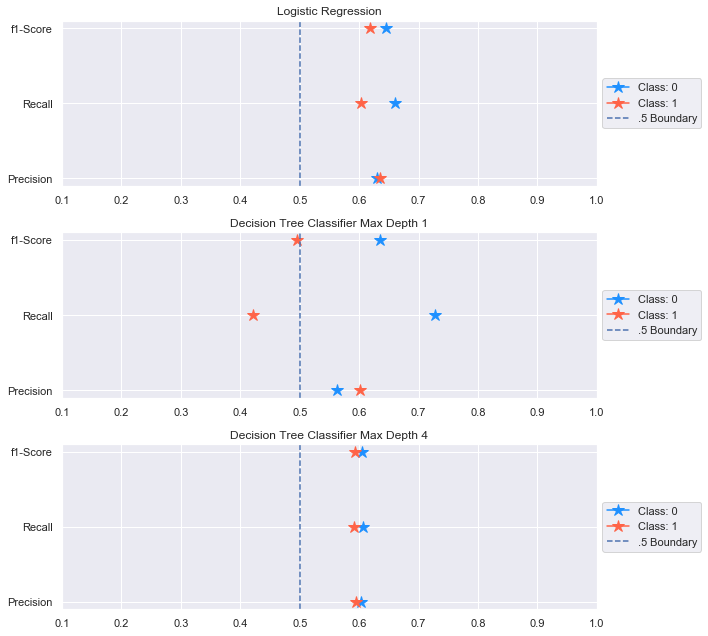

In [13]:
y = df_pca["shares"]
X = df_pca.drop(columns=['shares'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,random_state=93177)

rep_seed = 93177

# Define estimadores

estimators = [
    (
        "Logistic Regression",
        LogisticRegression(random_state=rep_seed)
    ),
    (
        "Decision Tree Classifier Max Depth 1",
        DecisionTreeClassifier(random_state=rep_seed, max_depth=1)
    ),
    (
        "Decision Tree Classifier Max Depth 4",
        DecisionTreeClassifier(random_state=rep_seed, max_depth=4)
    )
]


# Grafica métricas para cada estimador

plt.figure(figsize=(10,9))
for index, value in enumerate(estimators):
    plt.subplot(len(estimators),1,index+1)
    plt.title(value[0])
    y_pred = value[1].fit(X_train, y_train).predict(X_test)
    plot_classification_report_v2(y_test, y_pred)
    plt.xlim(0.1,1)


### Comentarios:

- 2 de los 3 modelos tienen métricas similares. (Decision Tree Classifier Max Depth 4 y Logistic Regression)
- El mejor desempeño se lo lleva la regresión logística con todas sus métricas sobre el 60%.

### Ejercicio 3 - Entrenamiento de Comité
* Entrene el comité de clasificadores sin modificar el esquema de votación.
* Reporte el desempeño a nivel de cada clase para cada métrica.

0            1  accuracy     macro avg  weighted avg
precision     0.607730     0.623294  0.614614      0.615512      0.615426
recall        0.670396     0.557582  0.614614      0.613989      0.614614
f1-score      0.637527     0.588610  0.614614      0.613068      0.613339
support    6614.000000  6469.000000  0.614614  13083.000000  13083.000000

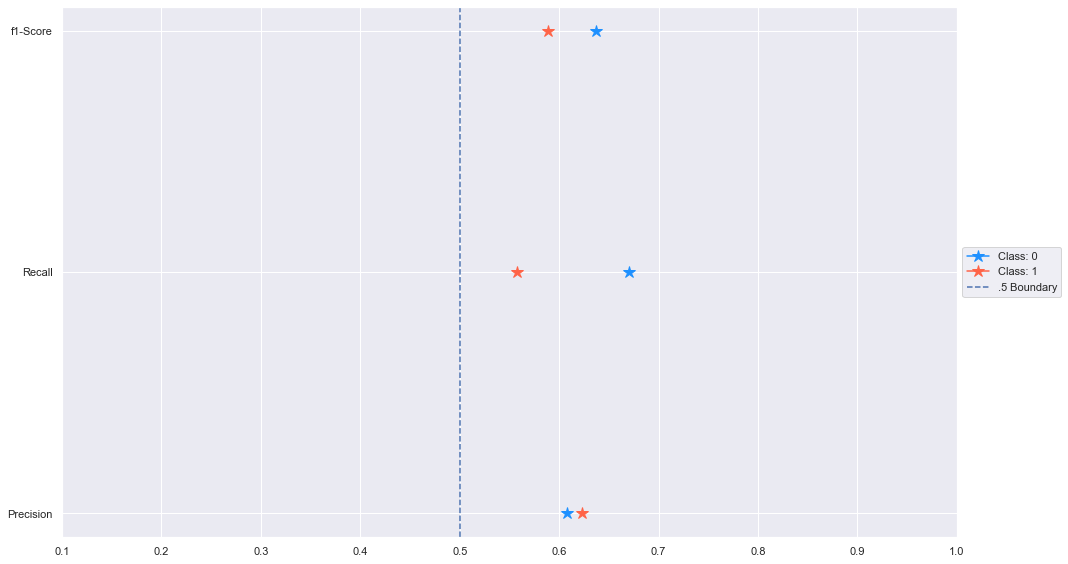

In [14]:
# entrenar el comité de clasificadores sin modificar el esquema de votación.

model_vot = VotingClassifier(estimators).fit(X_train, y_train)
voting_classifier_pred = model_vot.predict(X_test)


class_report_vot = classification_report(
    y_test, voting_classifier_pred, 
    output_dict=True
)
# reporte el desempeño a nivel de cada clase para cada métrica en un dataframe
class_report_vot = pd.DataFrame(class_report_vot)

display(class_report_vot)

plot_classification_report_v2(y_test, voting_classifier_pred)

### Comentarios:

-Todas las métricas tienden al promedio de los dos mejores clasificadores: logistic regression y decision tree.

El nivel de precisión esta por sobre el azar, al tener un score de 0.63 para la clase 0 y 0.61 para la clase 1.

### Ejercicio 4 - Calibración de Comité con Ponderadores
* En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
* Reporte el desempeño del mejor ensamble heterogéneo.

Text(0.5, 1, 'Esquema de Ponderación')

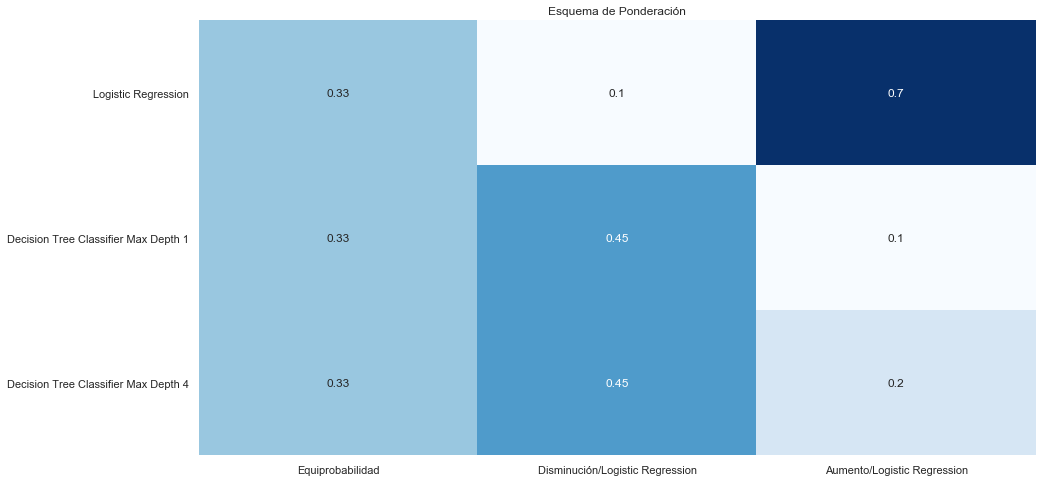

In [15]:
# definimos un diccionario con el esquema de ponderación a aplicar
weights_hyperparams = {'Equiprobabilidad': [1/3, 1/3, 1/3],
                       'Disminución/Logistic Regression': [.10, .45, .45],
                       'Aumento/Logistic Regression': [.70, .10, .20]
}

# implementamos la evaluación del modelo
weights = pd.DataFrame(weights_hyperparams, index =[i[0] for i in estimators])

sns.heatmap(weights, annot=True, cmap='Blues', cbar=False)
plt.title("Esquema de Ponderación")

In [16]:
weights.head()

Equiprobabilidad  \
Logistic Regression                           0.333333   
Decision Tree Classifier Max Depth 1          0.333333   
Decision Tree Classifier Max Depth 4          0.333333   

                                      Disminución/Logistic Regression  \
Logistic Regression                                              0.10   
Decision Tree Classifier Max Depth 1                             0.45   
Decision Tree Classifier Max Depth 4                             0.45   

                                      Aumento/Logistic Regression  
Logistic Regression                                           0.7  
Decision Tree Classifier Max Depth 1                          0.1  
Decision Tree Classifier Max Depth 4                          0.2

In [17]:
# entrenar el comité de clasificadores con ponderadores el esquema de votación.

for i in weights_hyperparams.values():
    
    model_comite = VotingClassifier(estimators, weights = i).fit(X_train, y_train)
    voting_classifier_comite = model_comite.predict(X_test)


    class_report_comite = classification_report(
        y_test, voting_classifier_comite, 
        output_dict=True
    )
    # reporte el desempeño a nivel de cada clase para cada métrica en un dataframe
    class_report_vot = pd.DataFrame(class_report_comite)
    display(class_report_vot)

0            1  accuracy     macro avg  weighted avg
precision     0.607730     0.623294  0.614614      0.615512      0.615426
recall        0.670396     0.557582  0.614614      0.613989      0.614614
f1-score      0.637527     0.588610  0.614614      0.613068      0.613339
support    6614.000000  6469.000000  0.614614  13083.000000  13083.000000

0            1  accuracy     macro avg  weighted avg
precision     0.607730     0.623294  0.614614      0.615512      0.615426
recall        0.670396     0.557582  0.614614      0.613989      0.614614
f1-score      0.637527     0.588610  0.614614      0.613068      0.613339
support    6614.000000  6469.000000  0.614614  13083.000000  13083.000000

0            1  accuracy     macro avg  weighted avg
precision     0.629763     0.634281  0.631889      0.632022      0.631997
recall        0.659661     0.603494  0.631889      0.631577      0.631889
f1-score      0.644366     0.618504  0.631889      0.631435      0.631578
support    6614.000000  6469.000000  0.631889  13083.000000  13083.000000

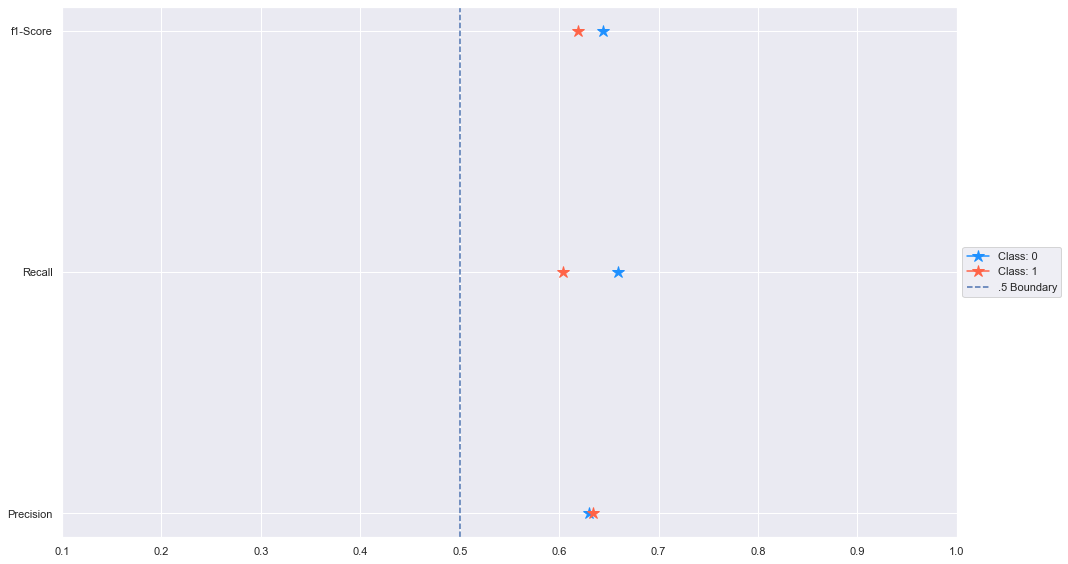

In [18]:
plot_classification_report_v2(y_test, voting_classifier_comite)

### Comentarios:

- Se selecciona la métrica f1 y recall para la clase shares igual a 1. El mejor ensamble heterogeneo es el Aumento/Logistic Regression. 

- Al comparar este resultado con el modelo anterior del punto 3, este modelo frente a su variación del peso ponderado mejora en 0.1 la predición para la clase 1.